**This workbook will aim at implementing an example use this cryptobacktest library**

The strategy we aim to implement is an options-based approach designed to capture potential increases in the volatility of the underlying asset. Specifically, we will utilize a strategy known as a straddle, which involves simultaneously purchasing a call and a put option with the same strike price and expiration date. This setup allows us to profit from significant price movements in either direction. To identify potential opportunities, we will focus on periods of low volatility, anticipating that an increase in volatility may follow.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

from cryptobacktest_yoen.volatility import Volatility
from cryptobacktest_yoen.option import Option
from cryptobacktest_yoen.volatilitysignal import StrictVolatilitySignal

from pybacktestchain.data_module import DataModule
from pybacktestchain.data_module import get_stock_data

from cryptobacktest_yoen.straddlebacktest import StraddleBacktest
from cryptobacktest_yoen.straddlebroker import StraddleBroker
from cryptobacktest_yoen.straddleinfo import StraddleInformation

In [2]:
# Define the date range
start_date = "2016-01-01"
end_date = "2024-12-31"

# Import historical data thanks to a pybacktestchain function
btc_data = get_stock_data('BTC-USD', start_date, end_date)
btc_data

,Date,Open,High,Low,Close,Adj Close,Volume,ticker
0,2016-01-01 00:00:00+00:00,430.721008,436.246002,427.515015,434.334015,434.334015,36278900,BTC-USD
1,2016-01-02 00:00:00+00:00,434.622009,436.062012,431.869995,433.437988,433.437988,30096600,BTC-USD
2,2016-01-03 00:00:00+00:00,433.578003,433.743011,424.705994,430.010986,430.010986,39633800,BTC-USD
3,2016-01-04 00:00:00+00:00,430.061005,434.516998,429.084015,433.091003,433.091003,38477500,BTC-USD
4,2016-01-05 00:00:00+00:00,433.069000,434.182007,429.675995,431.959991,431.959991,34522600,BTC-USD
...,...,...,...,...,...,...,...,...
3282,2024-12-26 00:00:00+00:00,99297.695312,99884.570312,95137.882812,95795.515625,95795.515625,47054980873,BTC-USD
3283,2024-12-27 00:00:00+00:00,95704.976562,97294.843750,93310.742188,94164.859375,94164.859375,52419934565,BTC-USD
3284,2024-12-28 00:00:00+00:00,94160.187500,95525.898438,94014.289062,95163.929688,95163.929688,24107436185,BTC-USD
3285,2024-12-29 00:00:00+00:00,95174.054688,95174.875000,92881.789062,93530.226562,93530.226562,29635885267,BTC-USD


We will be working on the closing price so we will only keep them.

In [3]:
btc_close = btc_data[['Date', 'Close']].copy()

# Ensure the date column is a datetime format
btc_close['Date'] = pd.to_datetime(btc_close['Date'])

btc_close

,Date,Close
0,2016-01-01 00:00:00+00:00,434.334015
1,2016-01-02 00:00:00+00:00,433.437988
2,2016-01-03 00:00:00+00:00,430.010986
3,2016-01-04 00:00:00+00:00,433.091003
4,2016-01-05 00:00:00+00:00,431.959991
...,...,...
3282,2024-12-26 00:00:00+00:00,95795.515625
3283,2024-12-27 00:00:00+00:00,94164.859375
3284,2024-12-28 00:00:00+00:00,95163.929688
3285,2024-12-29 00:00:00+00:00,93530.226562


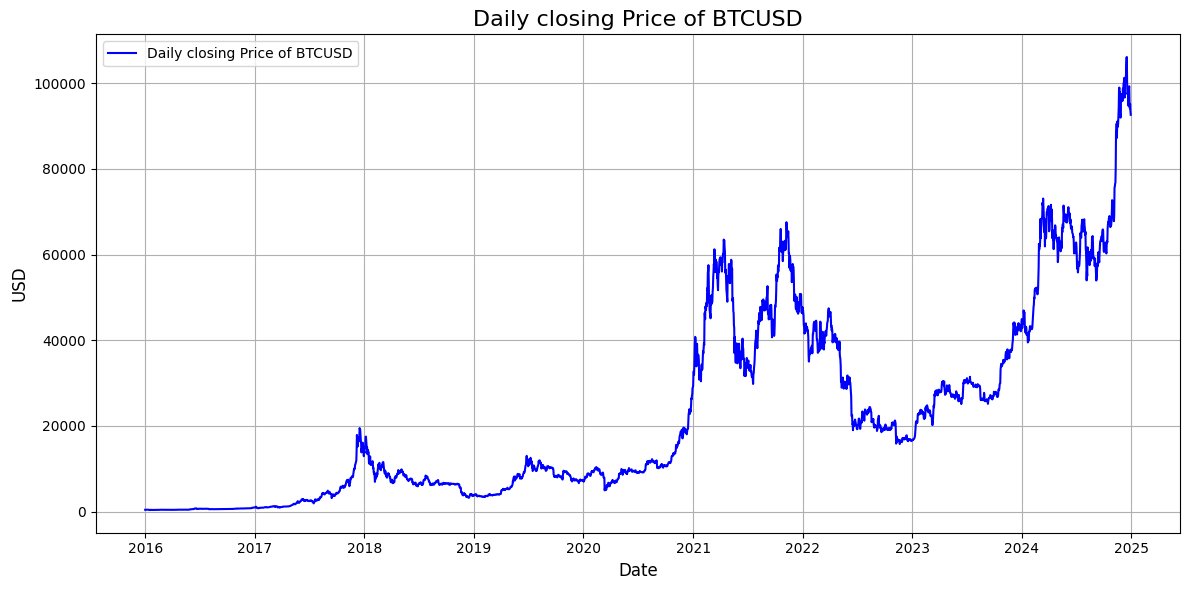

In [4]:
# Plot the Price
plt.figure(figsize=(12, 6))
plt.plot(btc_close['Date'], btc_close['Close'], label='Daily closing Price of BTCUSD', color='blue')
plt.title('Daily closing Price of BTCUSD', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('USD', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Initialize the Volatility class to compute a rolling monthly volatility

In [5]:
volatility_calculator = Volatility(window=360,factor=30)

# Compute monthly rolling volatility
btc_close = volatility_calculator.compute_volatility(btc_close, price_column='Close', date_column='Date')

In [6]:
btc_close

,Date,Close,Volatility
0,2016-01-01 00:00:00+00:00,434.334015,NaN
1,2016-01-02 00:00:00+00:00,433.437988,NaN
2,2016-01-03 00:00:00+00:00,430.010986,NaN
3,2016-01-04 00:00:00+00:00,433.091003,NaN
4,2016-01-05 00:00:00+00:00,431.959991,NaN
...,...,...,...
3282,2024-12-26 00:00:00+00:00,95795.515625,0.154039
3283,2024-12-27 00:00:00+00:00,94164.859375,0.154077
3284,2024-12-28 00:00:00+00:00,95163.929688,0.153431
3285,2024-12-29 00:00:00+00:00,93530.226562,0.153314


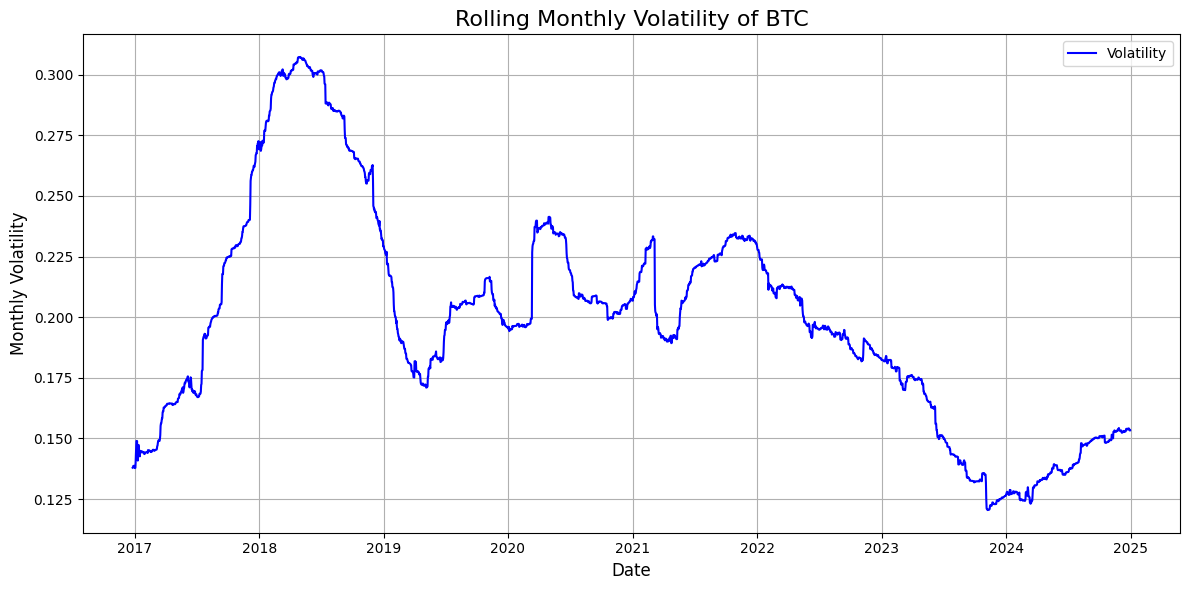

In [7]:
# Plot the rolling monthly volatility
plt.figure(figsize=(12, 6))
plt.plot(btc_close['Date'], btc_close['Volatility'], label='Volatility', color='blue')
plt.title('Rolling Monthly Volatility of BTC', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Monthly Volatility', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Compute the 30-day maturity straddle price for each dates


In [8]:
btc_close['StraddlePrice'] = btc_close.apply(
    lambda row: Option.compute_straddle(
        underlying_price=row['Close'],
        implied_volatility=row['Volatility'],
        time_to_maturity=30,  # 30-day maturity
        interest_rate=0.0,    # No interest rate
        dividend_yield=0.0    # No dividend yield
    ) if not pd.isna(row['Volatility']) else None,
    axis=1
)

btc_close

,Date,Close,Volatility,StraddlePrice
0,2016-01-01 00:00:00+00:00,434.334015,NaN,NaN
1,2016-01-02 00:00:00+00:00,433.437988,NaN,NaN
2,2016-01-03 00:00:00+00:00,430.010986,NaN,NaN
3,2016-01-04 00:00:00+00:00,433.091003,NaN,NaN
4,2016-01-05 00:00:00+00:00,431.959991,NaN,NaN
...,...,...,...,...
3282,2024-12-26 00:00:00+00:00,95795.515625,0.154039,3398.507632
3283,2024-12-27 00:00:00+00:00,94164.859375,0.154077,3341.501696
3284,2024-12-28 00:00:00+00:00,95163.929688,0.153431,3362.778973
3285,2024-12-29 00:00:00+00:00,93530.226562,0.153314,3302.548250


We now aim at computing potential buy straddle signals. To do this we will initialize our StrictVolatilitySignal class using the following parameters: a short-term volatility period of 1 month and a long-term volatility period of 3 months. Also we will only be interested in it if it's at least 5% lower for 3 consecutive days. Finally, we will take a maximum of 1 trade each 3 months to avoid taking many positions in the case the volatility decreases a lot very rapidly.

In [9]:
strict_signal_with_frequency = StrictVolatilitySignal(
    vol_column="Volatility", 
    date_column="Date", 
    short_window=30, 
    long_window=90, 
    threshold_factor=0.95, 
    min_days=3, 
    trading_frequency=90)

In [10]:
# Generating the sinals on our df 
btc_close_with_frequency_signals = strict_signal_with_frequency.generate_signals(btc_close)

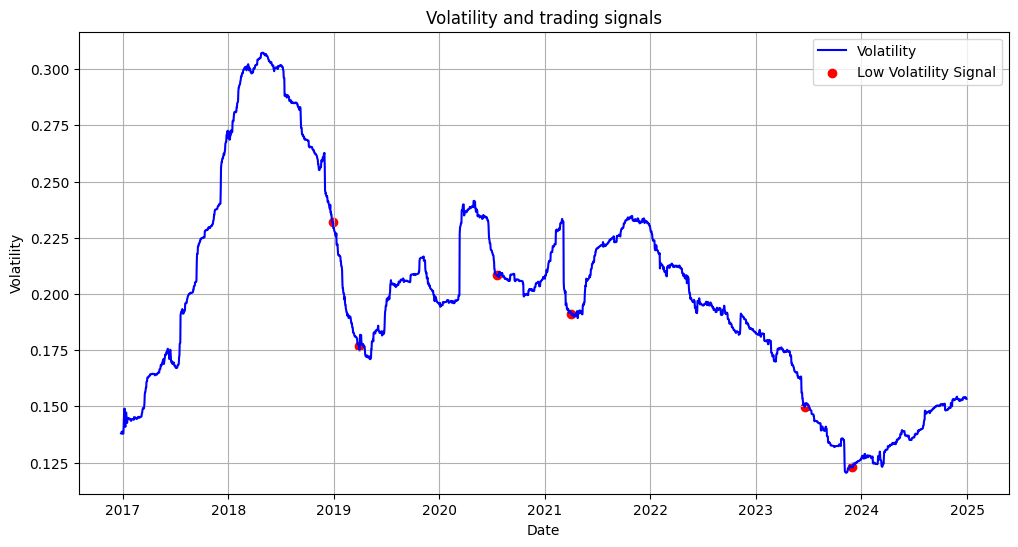

In [11]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(btc_close_with_frequency_signals['Date'], btc_close_with_frequency_signals['Volatility'], label='Volatility', color='blue')
plt.scatter(
    btc_close_with_frequency_signals['Date'][btc_close_with_frequency_signals['Signal'] == 1],
    btc_close_with_frequency_signals['Volatility'][btc_close_with_frequency_signals['Signal'] == 1],
    color='red', label='Low Volatility Signal'
)
plt.title('Volatility and trading signals')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()


Now by looking at volatility, spot and where our signals are, it's very hard to know if we would make money. 

Indeed straddles are expensive, so to know if this straddle strategy calibrated with our parameters would make money, we need to run a backtest ! 

Hence it's from here that will try to make the link between what I developed and the pybacktestchain created in class. As pybacktestchain was initially made for stocks and not options we will have to modify it a bit to fit our constraints. 

Indeed, with our option strategy we don't aim to rebalance our portfolio as we will keep positions until maturity and we will have no "risk model" as once bought we will hold them.

In [12]:
btc_close_with_frequency_signals

,Date,Close,Volatility,StraddlePrice,Signal
0,2016-01-01 00:00:00+00:00,434.334015,NaN,NaN,0
1,2016-01-02 00:00:00+00:00,433.437988,NaN,NaN,0
2,2016-01-03 00:00:00+00:00,430.010986,NaN,NaN,0
3,2016-01-04 00:00:00+00:00,433.091003,NaN,NaN,0
4,2016-01-05 00:00:00+00:00,431.959991,NaN,NaN,0
...,...,...,...,...,...
3282,2024-12-26 00:00:00+00:00,95795.515625,0.154039,3398.507632,0
3283,2024-12-27 00:00:00+00:00,94164.859375,0.154077,3341.501696,0
3284,2024-12-28 00:00:00+00:00,95163.929688,0.153431,3362.778973,0
3285,2024-12-29 00:00:00+00:00,93530.226562,0.153314,3302.548250,0


Now our dataset and strategy are ready to be backtested. We will initialiaze all the necessary classes and variables.

In [13]:
# Initialize the data module
data_module = DataModule(data=btc_close_with_frequency_signals)


In [14]:
# Initialize the information class
info = StraddleInformation(
    data_module=data_module,
    s=timedelta(days=360),
    time_column="Date",
    adj_close_column="Close"
)

In [15]:
# initialize the backtest
backtest = StraddleBacktest(
    initial_date=btc_close_with_frequency_signals["Date"].min(),
    final_date=btc_close_with_frequency_signals["Date"].max(),
    data_module=data_module,
    initial_cash=10000,  # Starting cash
    allocation_percent=0.1,  # Allocate 10% of portfolio to buying straddles at each date x, sort of risk parameter
)

Everything is now ready to run the backtest on the defined strategy.

In [16]:
backtest.run_backtest(information_class=info);

Processing date: 2016-01-01 00:00:00+00:00, Signal: 0
Processing date: 2016-01-02 00:00:00+00:00, Signal: 0
Processing date: 2016-01-03 00:00:00+00:00, Signal: 0
Processing date: 2016-01-04 00:00:00+00:00, Signal: 0
Processing date: 2016-01-05 00:00:00+00:00, Signal: 0
Processing date: 2016-01-06 00:00:00+00:00, Signal: 0
Processing date: 2016-01-07 00:00:00+00:00, Signal: 0
Processing date: 2016-01-08 00:00:00+00:00, Signal: 0
Processing date: 2016-01-09 00:00:00+00:00, Signal: 0
Processing date: 2016-01-10 00:00:00+00:00, Signal: 0
Processing date: 2016-01-11 00:00:00+00:00, Signal: 0
Processing date: 2016-01-12 00:00:00+00:00, Signal: 0
Processing date: 2016-01-13 00:00:00+00:00, Signal: 0
Processing date: 2016-01-14 00:00:00+00:00, Signal: 0
Processing date: 2016-01-15 00:00:00+00:00, Signal: 0
Processing date: 2016-01-16 00:00:00+00:00, Signal: 0
Processing date: 2016-01-17 00:00:00+00:00, Signal: 0
Processing date: 2016-01-18 00:00:00+00:00, Signal: 0
Processing date: 2016-01-19 

/opt/anaconda3/envs/cryptobacktest/lib/python3.12/site-packages/pybacktestchain/broker.py:115: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.transaction_log = pd.concat([self.transaction_log, transaction], ignore_index=True)


Processing date: 2019-01-16 00:00:00+00:00, Signal: 0
Processing date: 2019-01-17 00:00:00+00:00, Signal: 0
Processing date: 2019-01-18 00:00:00+00:00, Signal: 0
Processing date: 2019-01-19 00:00:00+00:00, Signal: 0
Processing date: 2019-01-20 00:00:00+00:00, Signal: 0
Processing date: 2019-01-21 00:00:00+00:00, Signal: 0
Processing date: 2019-01-22 00:00:00+00:00, Signal: 0
Processing date: 2019-01-23 00:00:00+00:00, Signal: 0
Processing date: 2019-01-24 00:00:00+00:00, Signal: 0
Processing date: 2019-01-25 00:00:00+00:00, Signal: 0
Processing date: 2019-01-26 00:00:00+00:00, Signal: 0
Processing date: 2019-01-27 00:00:00+00:00, Signal: 0
Processing date: 2019-01-28 00:00:00+00:00, Signal: 0
Processing date: 2019-01-29 00:00:00+00:00, Signal: 0
Processing date: 2019-01-30 00:00:00+00:00, Signal: 0
Processing date: 2019-01-31 00:00:00+00:00, Signal: 0
Processing date: 2019-02-01 00:00:00+00:00, Signal: 0
Processing date: 2019-02-02 00:00:00+00:00, Signal: 0
Processing date: 2019-02-03 

We will grab the results: portfolio value & P&L in a dataframe in order to do some graphs based on the strategy

In [17]:
portfolio_history, realized_pnl = backtest.get_results()

# Get all potential trade dates
trade_dates = btc_close_with_frequency_signals.loc[btc_close_with_frequency_signals["Signal"] == 1, "Date"]

#  only dates where trades occurred are considered (if cash < straddleprice, no trade)
successful_trade_dates = trade_dates.iloc[:len(realized_pnl)].reset_index(drop=True)

# Show pnl & cumulative pnl where trades were made

realized_pnl_df = pd.DataFrame({
    "Date": successful_trade_dates,
    "RealizedPnL": realized_pnl,
})
realized_pnl_df["CumulativePnL"] = realized_pnl_df["RealizedPnL"].cumsum()

realized_pnl_df



,Date,RealizedPnL,CumulativePnL
0,2018-12-29 00:00:00+00:00,855.627793,855.627793
1,2019-03-29 00:00:00+00:00,5843.188059,6698.815853
2,2020-07-19 00:00:00+00:00,6460.476918,13159.292771
3,2021-04-01 00:00:00+00:00,0.000000,13159.292771
4,2023-06-19 00:00:00+00:00,1075.775162,14235.067933
5,2023-12-01 00:00:00+00:00,7188.316851,21423.384785


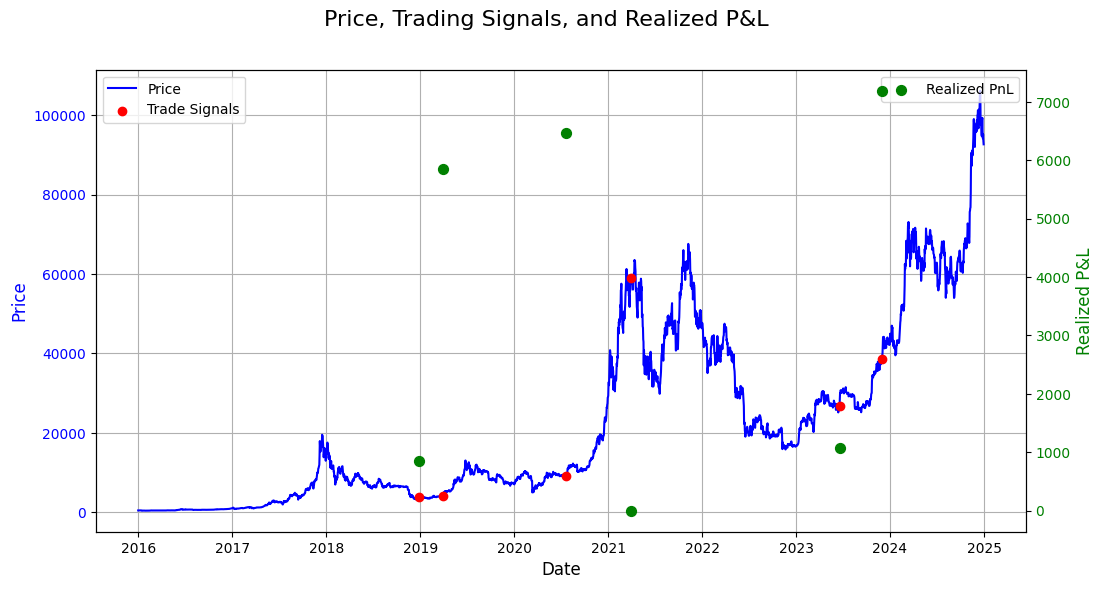

In [18]:
# Create graphs and parameters
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(
    btc_close_with_frequency_signals["Date"],
    btc_close_with_frequency_signals["Close"],
    label="Price",
    color="blue",
    linewidth=1.5,
)
ax1.scatter(
    btc_close_with_frequency_signals.loc[btc_close_with_frequency_signals["Signal"] == 1, "Date"],
    btc_close_with_frequency_signals.loc[btc_close_with_frequency_signals["Signal"] == 1, "Close"],
    color="red",
    label="Trade Signals",
    zorder=5,
)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Price", fontsize=12, color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.scatter(
    realized_pnl_df["Date"],
    realized_pnl_df["RealizedPnL"],
    color="green",
    label="Realized PnL",
    zorder=6,
    s=50,
)
ax2.set_ylabel("Realized P&L", fontsize=12, color="green")
ax2.tick_params(axis="y", labelcolor="green")
fig.suptitle("Price, Trading Signals, and Realized P&L", fontsize=16)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

ax1.grid()

plt.show()


Cumulative realized P&L:


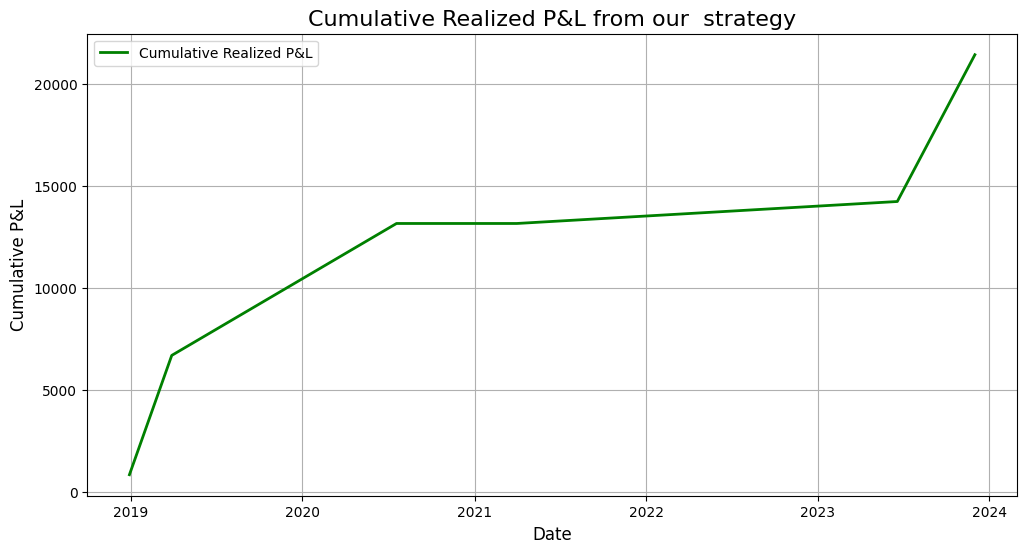

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(realized_pnl_df["Date"], realized_pnl_df["CumulativePnL"], label="Cumulative Realized P&L", color="green", linewidth=2)
plt.title("Cumulative Realized P&L from our  strategy", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative P&L", fontsize=12)
plt.legend()
plt.grid()
plt.show()

**Analysis of the P&L of this strategy:**

The results show that this strategy applied to BTC appears highly profitable. 

However, we need to be careful: 

Here, we used historical volatility as a proxy for implied volatility due to data limitations, which may not reflect real market conditions. 

Additionally, past performance of cryptocurrencies, driven by unique market conditions and rapid growth, may not be indicative of future performance.